In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_scaling_and_efficiency(df, name="ViT", min_node=1, **kw):
    """
    Render scaling and efficiency plots

    - Scaling plot is the relationship between the number of GPUs used
      and the speedup in the throughput
    - Efficiency is the ratio of throughput to ideal reference throughput
    """
    df = df.copy()
    # Number of GPUs per run
    df["GPUs"] = df["gpus"]
    df = df.sort_values(by="GPUs")

    # reference number of GPUs is the run with minimal number of GPUs
    refrence_nb_gpus = df.iloc[0]['GPUs']
    reference_samples_per_sec = df.iloc[0]['samples_per_sec']
    # reference throughput is the throughput of the configuration with the reference number of GPUs
    #reference_secs = df.iloc[0]["secs_per_batch"]
    #df["Speedup"] = (reference_secs / df['secs_per_batch']) * df['gpus']
    df["Speedup"] = df["samples_per_sec"] / reference_samples_per_sec
    # efficiency is the  $E(K) = 100 \times \frac{T(K)}{K \times T(1)}$, where:
    # - $K$ is the number of GPUs
    # - $T(K)$ is the throughput for $K$ GPUs
    # - $T(1)$ the reference throughput (for $K=1$)
    #df['efficiency'] =  reference_secs/ df["secs_per_batch"]
    df['efficiency'] =  df["samples_per_sec"] / ( (df['gpus']/refrence_nb_gpus) * reference_samples_per_sec)
    df_raw = df
    scale = df.Speedup.max() * 1.5
    top = 0
    text_spacing = 0.1

    df = df[df.nodes>=min_node]

    # plot
    fig, ax1 = plt.subplots(**kw)
    plt.xticks(fontsize=18) 
    plt.yticks(fontsize=22) 

    y = df['efficiency'] * 100#* scale + top

    ax1.set_ylabel('Efficiency (%)', color='red', fontsize=22)
    ax1.plot(df.GPUs, y, c='red', marker="o", label='efficiency')
    #ax1.plot(cs.gpus, cs.Efficiency, c='green', marker="o", label='efficiency')

    ax1.tick_params(axis='y', labelcolor='red')
    ax1.set_xlabel('GPUs', fontsize=15)
    
    for nb_gpus, effval, yval in zip(df.GPUs, df['efficiency'], y):
        ax1.text(nb_gpus, yval+text_spacing, f"{effval*100:.2f}%", size=16, c='red')
        
        
    ax2 = ax1.twinx()
    plt.xticks(fontsize=18) 
    plt.yticks(fontsize=22) 

    ax2.plot(df.GPUs, df.Speedup, 'go--', label=f'Speedup ({name})', color='blue')
    #ax2.plot(cs.gpus, cs.Speedup, 'go--', label='Speedup (CLIP ViT-B/32)', color='green')

    ax2.set_xlabel('GPUs')
    ax2.set_ylabel('Speedup',color='blue', fontsize=22)
    ax2.set_xticks(df.GPUs)
    ax2.plot(df.GPUs, df.GPUs / refrence_nb_gpus, 'go-', label='Ideal speedup', color='orange')

    ax2.tick_params(axis='y', labelcolor='blue')
    plt.xlabel("Number of GPUs (V100)")
    plt.legend(loc='upper center', fontsize=22)
    return df_raw

def plot_scaling(df, name="ViT", log=True, min_node=1, **kw):
    df = df.copy()
    # Number of GPUs per run
    df["GPUs"] = df["gpus"]
    df = df.sort_values(by="GPUs")
    # reference number of GPUs is the run with minimal number of GPUs
    refrence_nb_gpus = df.iloc[0]['GPUs']
    reference_samples_per_sec = df.iloc[0]['samples_per_sec']
    df["Speedup"] = df["samples_per_sec"] / reference_samples_per_sec
    df_raw = df
    scale = df.Speedup.max() * 1.5
    top = 0
    text_spacing = 0.1
    df = df[df.nodes>=min_node]
    fig, ax1 = plt.subplots(**kw)
    plt.xticks(fontsize=18) 
    plt.yticks(fontsize=22) 
    ax1.plot(np.log2(df.GPUs) if log else df.GPUs, df.Speedup, 'go--', label=f'Speedup ({name})', color='blue')
    #ax2.plot(cs.gpus, cs.Speedup, 'go--', label='Speedup (CLIP ViT-B/32)', color='green')
    ax1.yaxis.tick_right()
    
    ax1.set_xlabel('GPUs')
    ax1.set_ylabel('Speedup', fontsize=22)
    ax1.plot(np.log2(df.GPUs) if log else df.GPUs, df.GPUs / refrence_nb_gpus, 'go-', label='Ideal speedup', color='orange')
    if log:
        ax1.set_xticks(np.log2(df.GPUs), df.GPUs.apply(str))
    ax1.tick_params(axis='y', labelsize=22)
    plt.xlabel("Number of GPUs (A100)", fontsize=22)
    plt.legend(loc='upper center', fontsize=22)

    return df_raw

def plot_images_per_sec(df, name="ViT", **kw):
    """
    Render raw images per sec plot
    """
    df = df.copy()
    df["GPUs"] = df['gpus']
    df = df.sort_values(by="GPUs")
    df['Samples/s'] = ((df.batch_size) / df.secs_per_batch) * df.gpus
    df['Ideal'] = (df.batch_size / df.secs_per_batch.iloc[0]) * df.gpus
    fig = plt.figure(**kw)
    #ax= df.plot(x="GPUs",  y="Sample/s", color='pink', edgecolor='red', kind='bar')
    #df.plot(x="GPUs",  y="ideal", color='lightgreen', edgecolor='green', kind='bar',ax=ax)
    plt.xticks(fontsize=22) 
    plt.yticks(fontsize=22) 

    plt.bar(df['GPUs'].apply(str), df['Samples/s'], color='pink', edgecolor='red', label=f'Samples/s ({name})')
    plt.bar(df['GPUs'].apply(str), df['Ideal']-df['Samples/s'], color='red', edgecolor='red', bottom=df['Samples/s'], label='Ideal')
    plt.xlabel("Number of GPUs (A100)", fontsize=22)
    
    plt.legend(fontsize=22, loc='best')

In [9]:
import re
rows = []
files = glob("results/scaling2/**/**/*.out")
for path in files:
    _, _, arch, nodes, logfile = path.split("/")
    data = open(path, "r").read()
    if "Training time" not in data:
        continue
    lines = data.split("\n")
    batch_size_per_gpu = None
    for line in lines:
        if "batch_size_per_gpu" in line:
            batch_size_per_gpu = int(line.split(":")[1])
        
    lines = [float(re.search("time: ([0-9]+\.[0-9]+)", l).groups(1)[0]) for l in lines if "max mem:" in l]
    secs_per_batch = np.mean(lines[5:])
    
    row = {
        "name": arch,
        "nodes": int(nodes),
        "secs_per_batch": secs_per_batch,
        "batch_size": batch_size_per_gpu
    }
    rows.append(row)
df = pd.DataFrame(rows)
df["gpus"] = df["nodes"] * 4
df["samples_per_sec"] = (df["nodes"] * df["batch_size"]) / df["secs_per_batch"]
df["gpus_per_node"] = 4
df = df.sort_values(by="nodes")
df.to_csv("/p/home/jusers/cherti1/juwels/ccstdl/code/transfernetx_scaling/self_supervised_unimodal.csv", index=False)

In [10]:
df

,name,nodes,secs_per_batch,batch_size,gpus,samples_per_sec,gpus_per_node
2,vitb8,1,0.503571,8,4,15.886544,4
0,vitb8,2,0.506533,8,8,31.587281,4
1,vitb8,4,0.510250,8,16,62.714335,4
8,vitb8,8,0.509946,8,32,125.503485,4
4,vitb8,16,0.511469,8,64,250.259465,4
6,vitb8,32,0.511827,8,128,500.169165,4
5,vitb8,64,0.513857,8,256,996.385831,4
3,vitb8,128,0.515040,8,512,1988.195092,4
7,vitb8,256,0.516857,8,1024,3962.408711,4


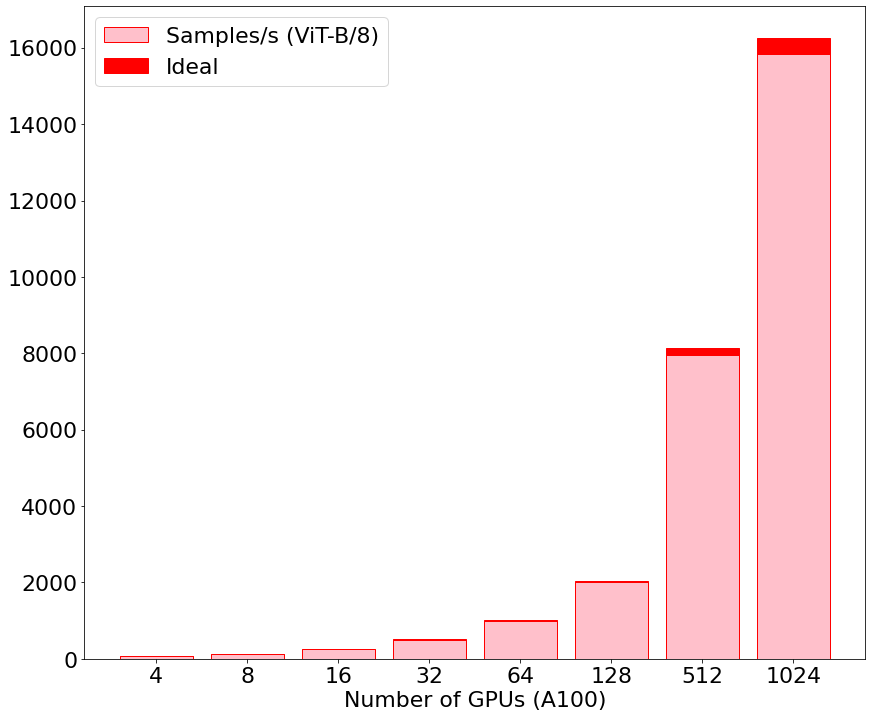

In [7]:
plot_images_per_sec(df, figsize=(14,12), name="ViT-B/8")

/tmp/ipykernel_19719/3260282105.py:66: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  ax2.plot(df.GPUs, df.Speedup, 'go--', label=f'Speedup ({name})', color='blue')
/tmp/ipykernel_19719/3260282105.py:72: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax2.plot(df.GPUs, df.GPUs / refrence_nb_gpus, 'go-', label='Ideal speedup', color='orange')


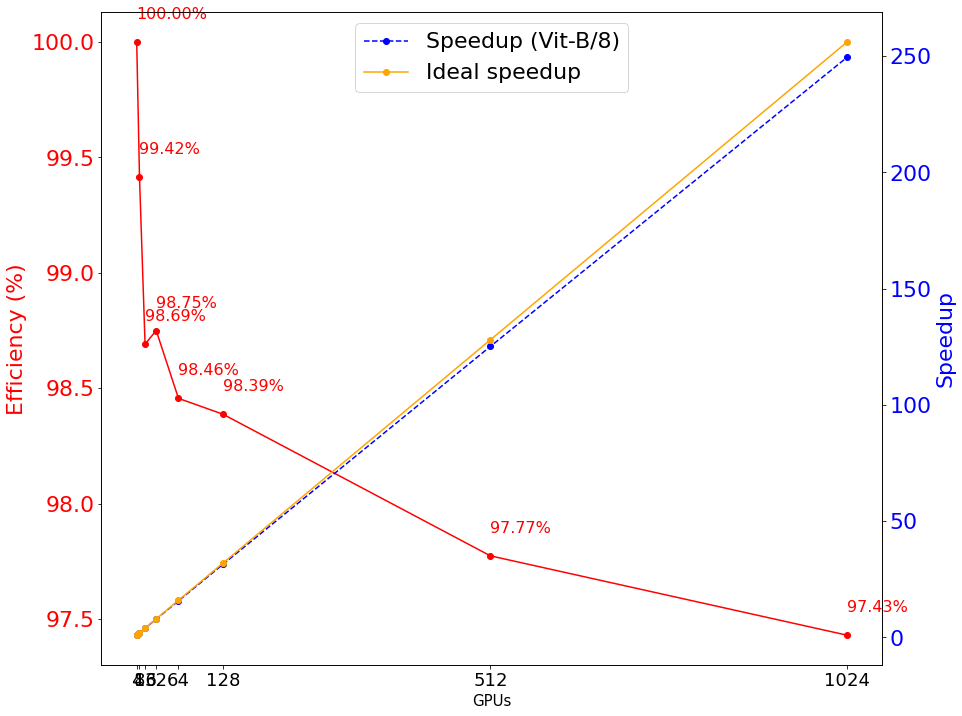

In [8]:
df_ext = plot_scaling_and_efficiency(df, figsize=(14,12),min_node=1, name="Vit-B/8")

In [61]:
def generate_table():
    s = ""
    s += "\\begin{tabular}{@{}ccrr@{}}\n"
    s += "\\toprule\n"
    s += "# Nodes & # GPUs & samples/sec & Efficiency (\\%)" + r"\\" + r"\midrule" + "\n"
    for _, row in df_ext.iterrows():
        s += f"{row.nodes} & {row.gpus_per_node*row.nodes} & {row.samples_per_sec:} & {row.efficiency*100:.2f}\\%"
        s += r"\\"
        s += "\n"
    s += r"\bottomrule"
    s += "\n"
    s += "\\end{tabular}\n"
    return s
print(generate_table())

\begin{tabular}{@{}ccrr@{}}
\toprule
# Nodes & # GPUs & samples/sec & Efficiency (\%)\\\midrule
1 & 4 & 16.042694958850486 & 100.00\%\\
2 & 8 & 31.926483949625325 & 99.50\%\\
4 & 16 & 63.49808993115418 & 98.95\%\\
8 & 32 & 126.81076861195706 & 98.81\%\\
16 & 64 & 252.59784384059236 & 98.41\%\\
32 & 128 & 503.01530823605697 & 97.98\%\\
64 & 256 & 1003.8808884868715 & 97.77\%\\
128 & 512 & 2000.5359508748602 & 97.42\%\\
\bottomrule
\end{tabular}

